In [38]:
import struct
import numpy as np
import cv2
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import seaborn as sns; sns.set()

In [39]:
def __convert_to_one_hot(vector, num_classes):
    result = np.zeros(shape=[len(vector), num_classes])
    result[np.arange(len(vector)), vector] = 1
    return result


def __resize_image(src_image, dst_image_height, dst_image_width):
    src_image_height = src_image.shape[0]
    src_image_width = src_image.shape[1]

    if src_image_height > dst_image_height or src_image_width > dst_image_width:
        height_scale = dst_image_height / src_image_height
        width_scale = dst_image_width / src_image_width
        scale = min(height_scale, width_scale)
        img = cv2.resize(src=src_image, dsize=(0, 0), fx=scale, fy=scale, interpolation=cv2.INTER_CUBIC)
    else:
        img = src_image

    img_height = img.shape[0]
    img_width = img.shape[1]

    dst_image = np.zeros(shape=[dst_image_height, dst_image_width], dtype=np.uint8)

    y_offset = (dst_image_height - img_height) // 2
    x_offset = (dst_image_width - img_width) // 2

    dst_image[y_offset:y_offset+img_height, x_offset:x_offset+img_width] = img

    return dst_image


def read_hoda_cdb(file_name):
    with open(file_name, 'rb') as binary_file:

        data = binary_file.read()

        offset = 0

        yy = struct.unpack_from('H', data, offset)[0]
        offset += 2

        m = struct.unpack_from('B', data, offset)[0]
        offset += 1

        d = struct.unpack_from('B', data, offset)[0]
        offset += 1

        H = struct.unpack_from('B', data, offset)[0]
        offset += 1

        W = struct.unpack_from('B', data, offset)[0]
        offset += 1

        TotalRec = struct.unpack_from('I', data, offset)[0]
        offset += 4

        LetterCount = struct.unpack_from('128I', data, offset)
        offset += 128 * 4

        imgType = struct.unpack_from('B', data, offset)[0]
        offset += 1

        Comments = struct.unpack_from('256c', data, offset)
        offset += 256 * 1

        Reserved = struct.unpack_from('245c', data, offset)
        offset += 245 * 1

        if (W > 0) and (H > 0):
            normal = True
        else:
            normal = False

        images = []
        labels = []

        for i in range(TotalRec):

            StartByte = struct.unpack_from('B', data, offset)[0]
            offset += 1

            label = struct.unpack_from('B', data, offset)[0]
            offset += 1

            if not normal:
                W = struct.unpack_from('B', data, offset)[0]
                offset += 1

                H = struct.unpack_from('B', data, offset)[0]
                offset += 1

            ByteCount = struct.unpack_from('H', data, offset)[0]
            offset += 2

            image = np.zeros(shape=[H, W], dtype=np.uint8)

            if imgType == 0:
                for y in range(H):
                    bWhite = True
                    counter = 0
                    while counter < W:
                        WBcount = struct.unpack_from('B', data, offset)[0]
                        offset += 1
                        if bWhite:
                            image[y, counter:counter + WBcount] = 0
                        else:
                            image[y, counter:counter + WBcount] = 255
                        bWhite = not bWhite
                        counter += WBcount
            else:
                data = struct.unpack_from('{}B'.format(W * H), data, offset)
                offset += W * H
                image = np.asarray(data, dtype=np.uint8).reshape([W, H]).T

            images.append(image)
            labels.append(label)

        return images, labels


def read_hoda_dataset(dataset_path, images_height=32, images_width=32, normalize=False, one_hot=False, reshape=True):
    images, labels = read_hoda_cdb(dataset_path)
    assert len(images) == len(labels)

    X = np.zeros(shape=[len(images), images_height, images_width], dtype=np.float32)
    Y = np.zeros(shape=[len(labels)], dtype=np.int)

    for i in range(len(images)):
        image = images[i]
        image = __resize_image(src_image=image, dst_image_height=images_height, dst_image_width=images_width)
        if normalize:
            image = image / 255
        X[i] = image
        Y[i] = labels[i]

    if one_hot:
        Y = __convert_to_one_hot(Y, 10).astype(dtype=np.float32)
    else:
        Y = Y.astype(dtype=np.float32)

    if reshape:
        X = X.reshape(-1, images_height * images_width)
    else:
        X = X.reshape(-1, images_height, images_width,)

    return X, Y

In [40]:
X_train, y_train = read_hoda_dataset(dataset_path='./Train 60000.cdb',
                         images_height=32,
                         images_width=32,
                         one_hot=False,
                         reshape=False)

X_test, Y_test = read_hoda_dataset(dataset_path='./Test 20000.cdb',
                         images_height=32,
                         images_width=32,
                         one_hot=False,
                         reshape=False)

X_train_normalized, y_train_normalized = read_hoda_dataset(dataset_path='./Train 60000.cdb',
                         images_height=32,
                         images_width=32,
                         one_hot=False,
                         reshape=False, normalize=True)

X_test_normalized, y_test_normalized = read_hoda_dataset(dataset_path='./Test 20000.cdb',
                         images_height=32,
                         images_width=32,
                         one_hot=False,
                         reshape=False, normalize=True)

In [41]:
import numpy as np

def knn_distances(xTrain,xTest,k):
    distances = -2 * xTrain@xTest.T + np.sum(xTest**2,axis=1) + np.sum(xTrain**2,axis=1)[:, np.newaxis]
    distances[distances < 0] = 0
    distances = distances**.5
    indices = np.argsort(distances, 0)
    distances = np.sort(distances,0)
    return indices[0:k,:], distances[0:k,:]

def knn_predictions(xTrain,yTrain,xTest,k=3):
    import numpy as np
    indices, distances = knn_distances(xTrain,xTest,k)
    yTrain = yTrain.flatten()
    rows, columns = indices.shape
    predictions = list()
    for j in range(columns):
        temp = list()
        for i in range(rows):
            cell = indices[i][j]
            temp.append(yTrain[cell])
        predictions.append(max(temp,key=temp.count))
    predictions=np.array(predictions)
    return predictions

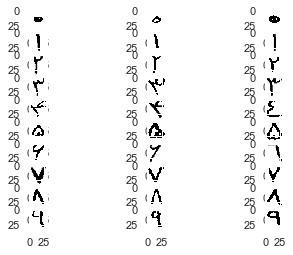

In [42]:
import matplotlib.pyplot as plt

images_and_labels = list(zip(X_train,y_train))
class_count = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
f, axarr = plt.subplots(10,3)
for image, label in images_and_labels:
    if class_count[int(label)] < 3:
        axarr[int(label),class_count[int(label)]].imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
        class_count[int(label)] += 1

In [43]:
X_train = X_train.reshape((60000, -1))
X_test = X_test.reshape((20000, -1))
X_train_normalized = X_train_normalized.reshape((60000, -1))
X_test_normalized = X_test_normalized.reshape((20000, -1))

# Without using Library

In [52]:
ypred = knn_predictions(X_train,y_train,X_test,k=3)

In [53]:
print(metrics.classification_report(ypred, Y_test))

              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99      2026
         1.0       1.00      0.92      0.96      2172
         2.0       0.94      0.88      0.91      2138
         3.0       0.88      0.94      0.91      1878
         4.0       0.93      0.97      0.95      1907
         5.0       0.96      1.00      0.98      1934
         6.0       0.97      0.98      0.98      1980
         7.0       0.98      0.99      0.99      1978
         8.0       0.99      0.97      0.98      2036
         9.0       0.96      0.98      0.97      1951

    accuracy                           0.96     20000
   macro avg       0.96      0.96      0.96     20000
weighted avg       0.96      0.96      0.96     20000



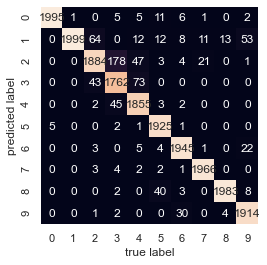

In [54]:
mat = confusion_matrix(Y_test, ypred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

In [55]:
ypred = knn_predictions(X_train_normalized,y_train_normalized,X_test_normalized,k=3)

In [57]:
print(metrics.classification_report(ypred, y_test_normalized))

              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99      2026
         1.0       1.00      0.92      0.96      2172
         2.0       0.94      0.88      0.91      2138
         3.0       0.88      0.94      0.91      1878
         4.0       0.93      0.97      0.95      1907
         5.0       0.96      1.00      0.98      1933
         6.0       0.97      0.98      0.98      1979
         7.0       0.98      0.99      0.99      1979
         8.0       0.99      0.97      0.98      2037
         9.0       0.96      0.98      0.97      1951

    accuracy                           0.96     20000
   macro avg       0.96      0.96      0.96     20000
weighted avg       0.96      0.96      0.96     20000



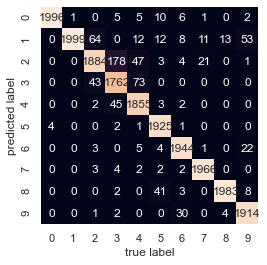

In [58]:
mat = confusion_matrix(y_test_normalized, ypred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

# With using Library

In [44]:
model = KNeighborsClassifier(n_neighbors=3)
model.fit(X_train, y_train)
ypred = model.predict(X_test)

In [46]:
print(metrics.classification_report(ypred, Y_test))

              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99      2031
         1.0       1.00      0.92      0.96      2179
         2.0       0.94      0.87      0.91      2162
         3.0       0.88      0.94      0.91      1866
         4.0       0.92      0.98      0.95      1894
         5.0       0.96      1.00      0.98      1931
         6.0       0.97      0.98      0.98      1976
         7.0       0.98      0.99      0.99      1977
         8.0       0.99      0.97      0.98      2036
         9.0       0.96      0.98      0.97      1948

    accuracy                           0.96     20000
   macro avg       0.96      0.96      0.96     20000
weighted avg       0.96      0.96      0.96     20000



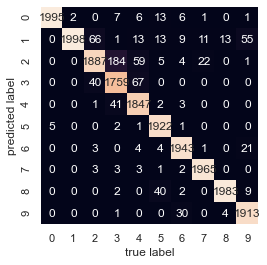

In [47]:
mat = confusion_matrix(Y_test, ypred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

In [48]:
model = KNeighborsClassifier(n_neighbors=3)
model.fit(X_train_normalized, y_train_normalized)
ypred = model.predict(X_test_normalized)

In [49]:
print(metrics.classification_report(ypred, y_test_normalized))

              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99      2031
         1.0       1.00      0.92      0.96      2179
         2.0       0.94      0.87      0.91      2162
         3.0       0.88      0.94      0.91      1866
         4.0       0.92      0.98      0.95      1894
         5.0       0.96      1.00      0.98      1931
         6.0       0.97      0.98      0.98      1976
         7.0       0.98      0.99      0.99      1977
         8.0       0.99      0.97      0.98      2036
         9.0       0.96      0.98      0.97      1948

    accuracy                           0.96     20000
   macro avg       0.96      0.96      0.96     20000
weighted avg       0.96      0.96      0.96     20000



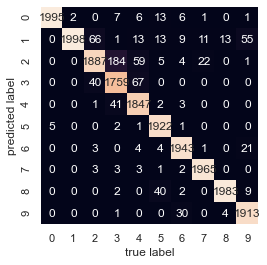

In [51]:
mat = confusion_matrix(y_test_normalized, ypred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');